In [1]:
!pip install keras
!pip install opencv-python
!pip install tensorflow-addons

     |████████████████████████████████| 1.8MB 4.9MB/s 
     |████████████████████████████████| 380.8MB 38kB/s 
     |████████████████████████████████| 3.8MB 36.7MB/s 
     |████████████████████████████████| 450kB 58.1MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Su

In [0]:
import os
from google.colab import auth
auth.authenticate_user()

In [0]:
%%capture
!gsutil cp -r gs://steel-data/data/train.zip /content
!unzip /content/train.zip
!gsutil cp -r gs://steel-data/data/train.csv /content
!gsutil cp -r gs://steel-data/data/sample_submission.csv /content
os.chdir('/content/')

In [3]:
for file in os.listdir():
  if file == "sample_submission.csv":
    print(file)


sample_submission.csv


In [0]:

import os
import json
import random

import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

In [0]:
ONLY_CLASSIFY = True
IMAGE_CHANNELS = 3

## PREPROCESSING

In [88]:
traindf=pd.read_csv('train.csv')
traindf['ImageId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
traindf['ClassId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
traindf['hasMask'] = ~ traindf['EncodedPixels'].isna()
traindf.head()

ImageId_ClassId  ... hasMask
0  0002cc93b.jpg_1  ...    True
1  0002cc93b.jpg_2  ...   False
2  0002cc93b.jpg_3  ...   False
3  0002cc93b.jpg_4  ...   False
4  00031f466.jpg_1  ...   False

[5 rows x 5 columns]

In [89]:
maskcountdf = traindf.groupby('ImageId').agg(np.sum).reset_index()
maskcountdf.sort_values('hasMask', ascending=True, inplace=True)
print(maskcountdf.shape)
maskcountdf.head()

(12568, 2)


ImageId  hasMask
4060  5267fdd89.jpg      0.0
4958  64a9ec83c.jpg      0.0
9888  c8b9b27b9.jpg      0.0
4954  64945c8c0.jpg      0.0
9889  c8bb69681.jpg      0.0

In [0]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

## UTILITY

In [0]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [0]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

def rles_classvect(rles):
    depth = len(rles)
    masks = np.zeros((depth))

    for i, rle in enumerate(rles):
      if type(rle) is str:
          masks[i] = 1
 
    return masks

def random_flip(img):
    seed = random.randint(1,5)
    if seed % 3 == 0:
      img = np.flip(img, 0)
    if seed % 4 == 0:
      img = np.flip(img, 1)
    return img

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

## Sample

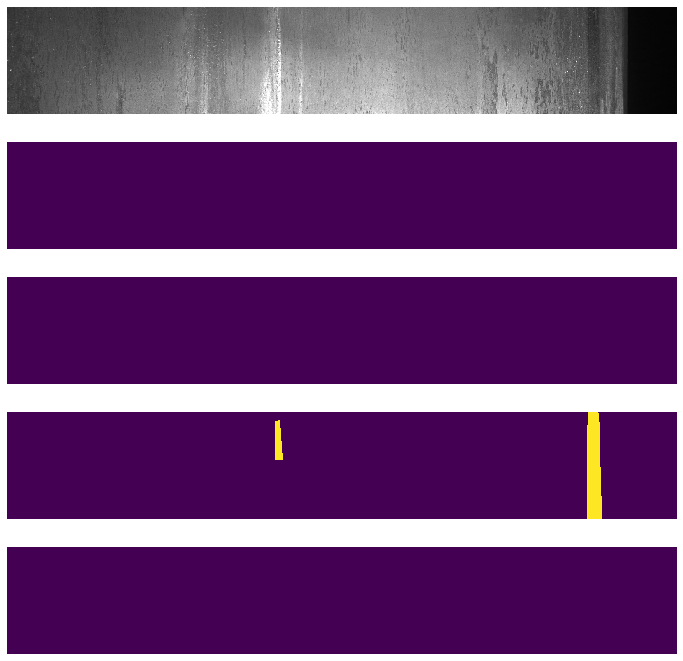

In [11]:
#/kaggle/input/severstal-steel-defect-detection/train_images/910540b7d.jpg
sample_filename = '910540b7d.jpg'
sample_image_df = traindf[traindf['ImageId'] == sample_filename]
sample_path = f"{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

## Data Generation

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True, 
                 classify=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.classify = classify
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, self.classify)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            if self.n_channels == 3:
              img = self.__load_rgb(img_path)
            else:
              img = self.__load_grayscale(img_path)
            img = random_flip(img)

            # Store samples
            X[i,] = img
        return X

    def __generate_y(self, list_IDs_batch, classify=False):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        if classify:
          y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            rles = image_df['EncodedPixels'].values
            if classify:
              masks = rles_classvect(rles)
            else:
              masks = build_masks(rles, input_shape=self.dim)
              
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = cv2.resize(img, (self.dim[1], self.dim[0]))
        img = np.expand_dims(img, axis=-1)
        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.dim[1], self.dim[0]))
        img = img.astype(np.float32) / 255.
        return img


In [0]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    maskcountdf.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=maskcountdf,
    target_df=traindf,
    dim=(64, 400),
    batch_size=BATCH_SIZE, 
    n_classes=4,
    n_channels=IMAGE_CHANNELS,
    classify=ONLY_CLASSIFY
)

val_generator = DataGenerator(
    val_idx, 
    df=maskcountdf,
    target_df=traindf,
    dim=(64, 400),
    batch_size=BATCH_SIZE, 
    n_classes=4,
    n_channels=IMAGE_CHANNELS,
    classify=ONLY_CLASSIFY
)

In [0]:
def build_model(input_shape):

    ### Resnet 50
    pretrained_model = keras.applications.ResNet50V2(input_shape=input_shape, include_top=False)  #classes=5
    model = keras.Sequential([
        pretrained_model,
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation='sigmoid'),
        keras.layers.Dense(4, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.SGD(), 
        loss=keras.losses.binary_crossentropy, 
        metrics=[tf.metrics.AUC()])
    return model

In [117]:
model = build_model((64, 400, IMAGE_CHANNELS))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2, 13, 2048)       23564800  
_________________________________________________________________
flatten_9 (Flatten)          (None, 53248)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                851984    
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
Total params: 24,416,852
Trainable params: 24,371,412
Non-trainable params: 45,440
_________________________________________________________________


In [0]:
checkpoint = ModelCheckpoint(
    'steel_only_defect_resnet50_f1_lyr_model.h5', 
    monitor='val_auc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    model='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=True,
    epochs=40,
    verbose=1
)

Epoch 1/40
667/667 [==============================] - 180s 269ms/step - loss: 0.3072 - auc_1: 0.8716 - val_loss: 0.2530 - val_auc_1: 0.9144
Epoch 2/40
667/667 [==============================] - 180s 270ms/step - loss: 0.2277 - auc_1: 0.9370 - val_loss: 0.2124 - val_auc_1: 0.9527
Epoch 3/40
667/667 [==============================] - 181s 271ms/step - loss: 0.1869 - auc_1: 0.9653 - val_loss: 0.1705 - val_auc_1: 0.9691
Epoch 4/40
667/667 [==============================] - 178s 267ms/step - loss: 0.1557 - auc_1: 0.9768 - val_loss: 0.1555 - val_auc_1: 0.9707
Epoch 5/40
667/667 [==============================] - 178s 267ms/step - loss: 0.1333 - auc_1: 0.9821 - val_loss: 0.1473 - val_auc_1: 0.9719
Epoch 6/40
667/667 [==============================] - 178s 266ms/step - loss: 0.1159 - auc_1: 0.9867 - val_loss: 0.1377 - val_auc_1: 0.9744
Epoch 7/40
667/667 [==============================] - 185s 277ms/step - loss: 0.1027 - auc_1: 0.9895 - val_loss: 0.1373 - val_auc_1: 0.9730
Epoch 8/40
667/667 [

In [1]:

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['auc', 'val_auc']].plot()

NameError: ignored

In [0]:
model.save('/home/steel_only_defect_resnet50_f1_lyr_model.h5')